In [3]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

import pickle

In [4]:
data = pd.read_csv('heart_2020_cleaned.csv')
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [5]:
data = data.drop(columns=['Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Diabetic', 'KidneyDisease', 'SkinCancer', 'Asthma'])

In [6]:
# object Dtype으로 되어있는 'AgeCategory' '-'로 split 후 중앙값으로 전처리

splite_str = data.loc[data['AgeCategory'].str.contains('-'), 'AgeCategory'].str.split('-', expand=True)
splite_str[0] = pd.to_numeric(splite_str[0])
splite_str[1] = pd.to_numeric(splite_str[1])
data.loc[data['AgeCategory'].str.contains('-'), 'AgeCategory'] = (splite_str[0] + splite_str[1]) / 2

# 'AgeCategory' column에서 'or older'을 제거

data.loc[data['AgeCategory'].str.contains('or') == True, 'AgeCategory'] = data.loc[data['AgeCategory'].str.contains('or') == True, 'AgeCategory'].str.replace('or older', '')
data['AgeCategory'] = pd.to_numeric(data['AgeCategory'])

In [7]:
encoded_df = data.copy()

##Label Encoding
le = preprocessing.LabelEncoder()
cols=['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Sex', 'PhysicalActivity']

for i in cols:
    encoded_df[i] = le.fit_transform(encoded_df[i])
    
le_1=le.fit(encoded_df['GenHealth'])
le_1.classes_ = np.array(['Poor', 'Fair','Good','Very good','Excellent'])   ## to assign 0 to Poor and 4 to Excellent
encoded_df['GenHealth'] = le_1.transform(encoded_df['GenHealth'])

## One hot encoding
encoded_df=pd.concat([encoded_df,pd.get_dummies(encoded_df['Race'],prefix='Race',drop_first=True)], axis=1)

encoded_df.drop(columns=['Race'],axis=1,inplace=True)

In [8]:
encoded_df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0,16.60,1,0,0,57.0,1,3,5.0,0,0,0,0,1
1,0,20.34,0,0,0,80.0,1,3,7.0,0,0,0,0,1
2,0,26.58,1,0,1,67.0,1,1,8.0,0,0,0,0,1
3,0,24.21,0,0,0,77.0,0,2,6.0,0,0,0,0,1
4,0,23.71,0,0,0,42.0,1,3,8.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,1,62.0,0,1,6.0,0,0,1,0,0
319791,0,29.84,1,0,1,37.0,1,3,5.0,0,0,1,0,0
319792,0,24.24,0,0,0,47.0,1,2,6.0,0,0,1,0,0
319793,0,32.81,0,0,0,27.0,0,2,12.0,0,0,1,0,0


In [9]:
# train set, test set split

train, test = train_test_split(encoded_df, train_size=0.8, test_size=0.2, random_state=42)
train.shape, test.shape

((255836, 14), (63959, 14))

In [10]:
X_train = train.drop(columns='HeartDisease')
y_train = train['HeartDisease']
X_test = test.drop(columns='HeartDisease')
y_test = test['HeartDisease']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((255836, 13), (255836,), (63959, 13), (63959,))

In [11]:
sc = StandardScaler()

encod_stand_df = sc.fit_transform(X_train)
encod_stand_df = sc.fit_transform(X_test)

In [12]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.set_params(n_estimators=500, 
                    class_weight="balanced",
                    max_depth=30,
                    min_samples_split= 30,
                    min_samples_leaf=24)

model_rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=24, min_samples_split=30,
                       n_estimators=500, random_state=42)

In [13]:
y_pred = model_rf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("\n\t\t\tClassification report\n",classification_report(y_test, y_pred))

Accuracy: 0.7460560671680295

			Classification report
               precision    recall  f1-score   support

           0       0.97      0.75      0.84     58367
           1       0.22      0.74      0.34      5592

    accuracy                           0.75     63959
   macro avg       0.59      0.74      0.59     63959
weighted avg       0.90      0.75      0.80     63959



/Users/simcheol-u/opt/anaconda3/envs/heart_analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


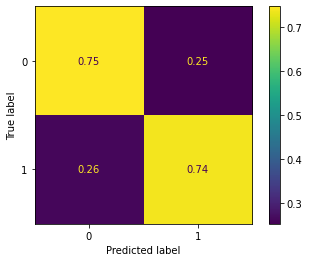

In [14]:
plot_confusion_matrix(model_rf,X_test,y_test,normalize='true')

In [20]:
print(X_train.iloc[0])
print(type(X_train.iloc[0]))

BMI                 23.33
Smoking              1.00
AlcoholDrinking      0.00
Sex                  1.00
AgeCategory         77.00
PhysicalActivity     1.00
GenHealth            3.00
SleepTime            7.00
Race_Asian           0.00
Race_Black           0.00
Race_Hispanic        0.00
Race_Other           0.00
Race_White           1.00
Name: 95877, dtype: float64
<class 'pandas.core.series.Series'>


In [21]:
X_test = [[20, 0, 0, 0, 77, 1, 3, 7, 0, 0, 0, 0, 1]]

In [23]:
y_pred = model_rf.predict(X_test)

/Users/simcheol-u/opt/anaconda3/envs/heart_analysis/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [24]:
y_pred

array([0])

In [36]:
# with open('model2.pkl', 'wb') as pickle_file:
#     pickle.dump(model_rf, pickle_file)